In [4]:
from scipy.spatial.distance import cdist
import pandas as pd

import itertools
from src.objects.customer import Customer
from src.aco.aco import ACO
from src.nearest_neighbor import NNO
import src.printer as pr
import random
import src.nearest_neighbor as nn

In [5]:
def instance_generator(customer_count, rand_seed=0):
    """
    Generates a random instance of the vehicle routing problem.

    Returns:
    tuple: List of customer objects and the depot object., number of trucks, capacity of each truck
    """
    random.seed(rand_seed)  # Set the random seed for reproducibility
    
    customers = []
    
    # Number of trucks
    truck_count = random.randint(10, 75)
    
    # Capacity of each truck
    capacity = random.randint(10, 50) * 10

    # Number of customers
    num_customers = customer_count
    
    # Generate random service time for the customer
    service_time = random.randint(1, 5) * 10

    for i in range(1, num_customers + 1):

        # Generate random demand for the customer
        demand = random.randint(1, 10) * 10
        
        # Generate random coordinates for the customer
        x_coord = random.uniform(0, 100)
        y_coord = random.uniform(0, 100)

        # Generate random ready time for the customer
        ready_time = random.randint(0, 1000)

        # Generate random due date for the customer
        due_date = ready_time + random.randint(100, 300)

        # Create a Customer object and add it to the list of customers
        customers.append(Customer(i, x_coord, y_coord, demand, ready_time, due_date, service_time))

    # Generate the depot (warehouse) at the center of the customers
    depot = Customer(0, sum(customer.x_coord for customer in customers) / num_customers, sum(customer.y_coord for customer in customers) / num_customers, 0, 0, max(x.due_date for x in customers) + service_time + 100, 0)

    return [depot] + customers, truck_count, capacity

Reading dataset -> dataset/c1_2_1.txt
--------------------------------------------------
Nearest Neighbor Solution:
Total distance traveled by the trucks: 1227.64
Path: depot -> 107 -> 39 -> 78 -> 155 -> 175 -> 2 -> 90 -> 67 -> 17 -> 113 -> 13 -> 43 -> 139 -> 6 -> 11 -> 122 -> 129 -> 73 -> 116 -> 12 -> 91 -> 164 -> 66 -> 47 -> 160 -> 147 -> 70 -> 148 -> 103 -> 197 -> 124 -> 141 -> 69 -> 200 -> 136 -> 189 -> 32 -> 171 -> 51 -> 94 -> 65 -> 86 -> 115 -> 174 -> 110 -> 77 -> 172 -> 25 -> 31 -> 80 -> 85 -> 41 -> 20 -> 24 -> 61 -> 100 -> 64 -> 27 -> 173 -> 154 -> 179 -> 45 -> 109 -> 178 -> 149 -> 74 -> 28 -> 97 -> 196 -> 192 -> 19 -> 120 -> 30 -> 68 -> 146 -> 102 -> 44 -> 131 -> 62 -> 76 -> 130 -> 96 -> 59 -> 14 -> 198 -> 152 -> 40 -> 26 -> 153 -> 169 -> 89 -> 105 -> 15 -> 133 -> 48 -> 123 -> 42 -> 50 -> 156 -> 112 -> 168 -> 79 -> 29 -> 87 -> 134 -> 170 -> 195 -> 52 -> 92 -> 23 -> 75 -> 163 -> 194 -> 145 -> 182 -> 21 -> 38 -> 150 -> 22 -> 159 -> 151 -> 16 -> 140 -> 187 -> 142 -> 111 -> 63 -> 

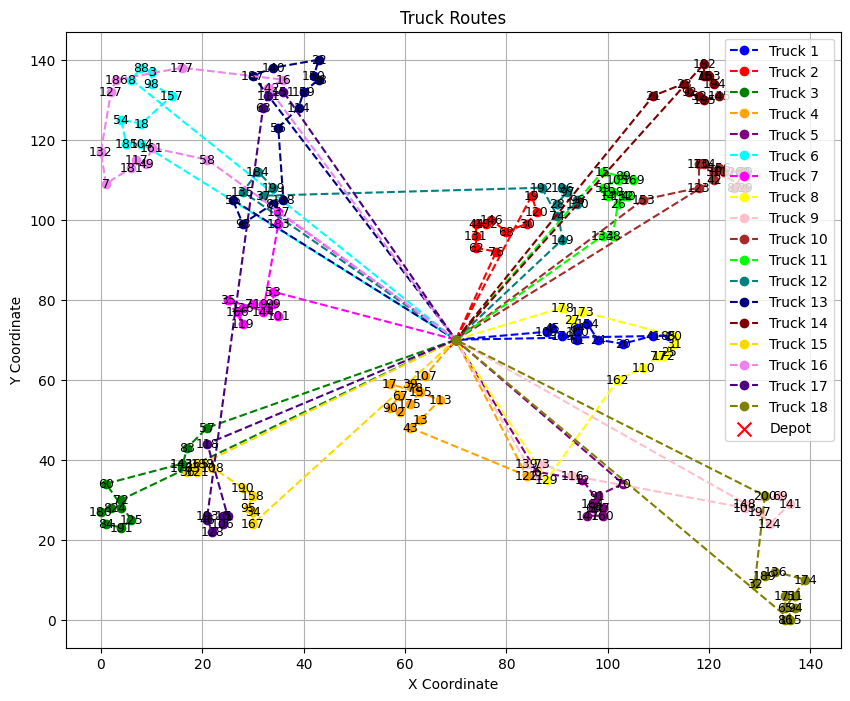

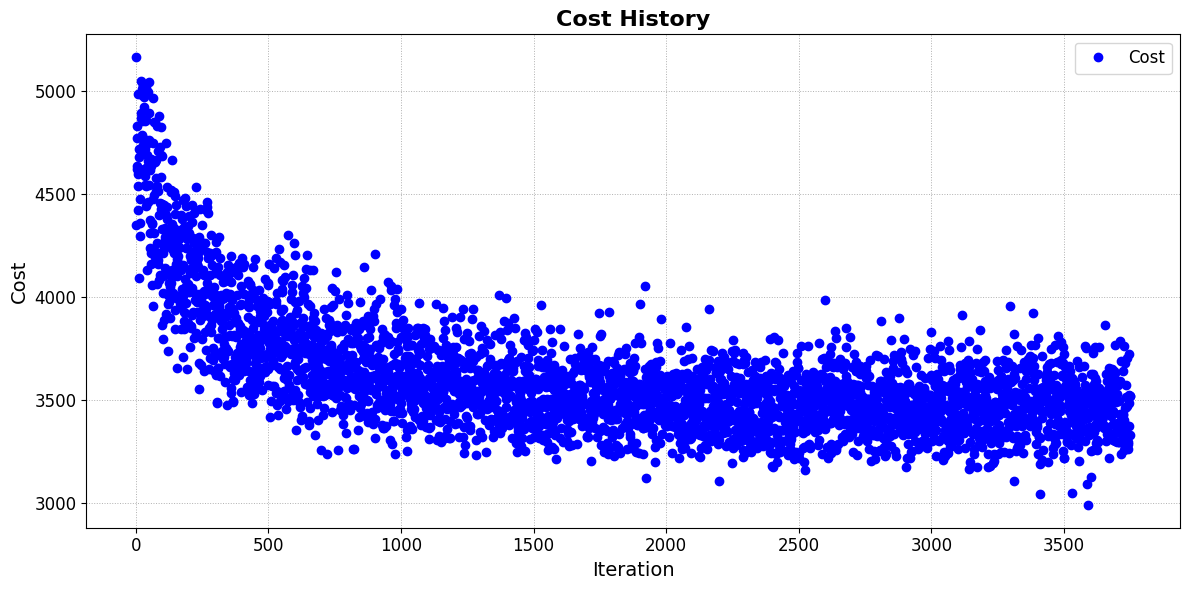

--------------------------------------------------
Truck #1
Path: depot -> 109 -> 45 -> 179 -> 61 -> 100 -> 64 -> 154 -> 24 -> 20 -> 41 -> 85 -> depot
Capacity used = 200
Total distance = 91.66
Total time = 1081.66


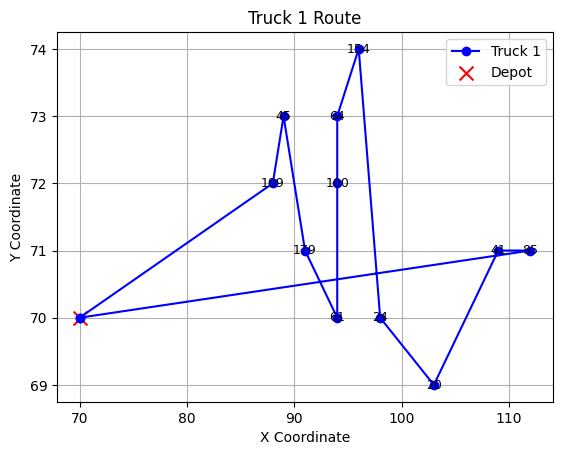

--------------------------------------------------
Truck #2
Path: depot -> 76 -> 62 -> 131 -> 44 -> 102 -> 146 -> 68 -> 30 -> 120 -> 19 -> depot
Capacity used = 200
Total distance = 92.39
Total time = 992.39


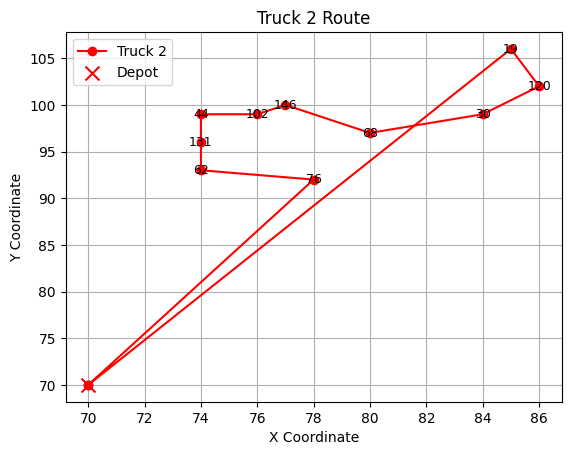

--------------------------------------------------
Truck #3
Path: depot -> 72 -> 4 -> 82 -> 180 -> 84 -> 191 -> 125 -> 60 -> 143 -> 176 -> 83 -> 57 -> depot
Capacity used = 200
Total distance = 184.89
Total time = 1264.89


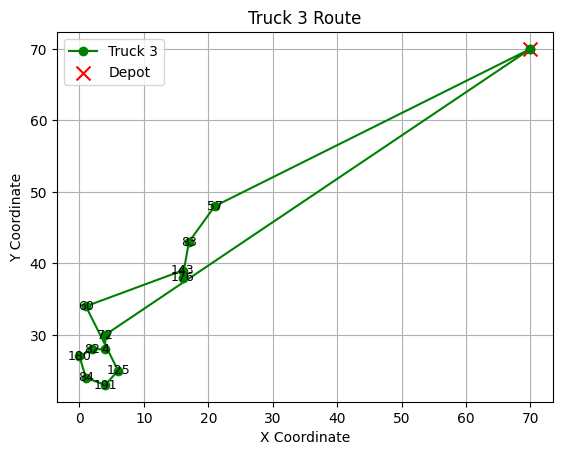

--------------------------------------------------
Truck #4
Path: depot -> 107 -> 39 -> 78 -> 155 -> 175 -> 2 -> 90 -> 67 -> 17 -> 113 -> 13 -> 43 -> 122 -> depot
Capacity used = 190
Total distance = 115.85
Total time = 1285.85


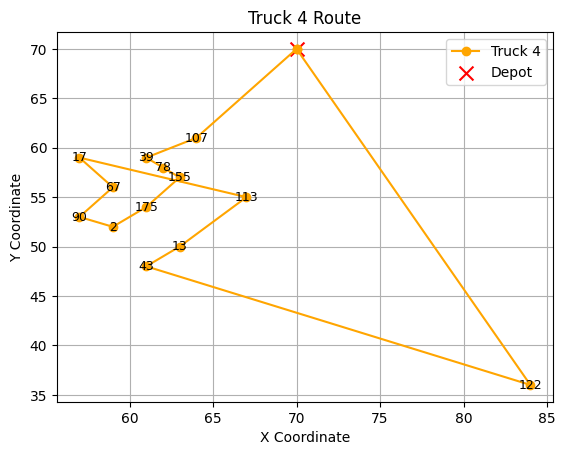

--------------------------------------------------
Truck #5
Path: depot -> 70 -> 91 -> 164 -> 66 -> 147 -> 160 -> 47 -> 12 -> 6 -> depot
Capacity used = 200
Total distance = 119.10
Total time = 929.10


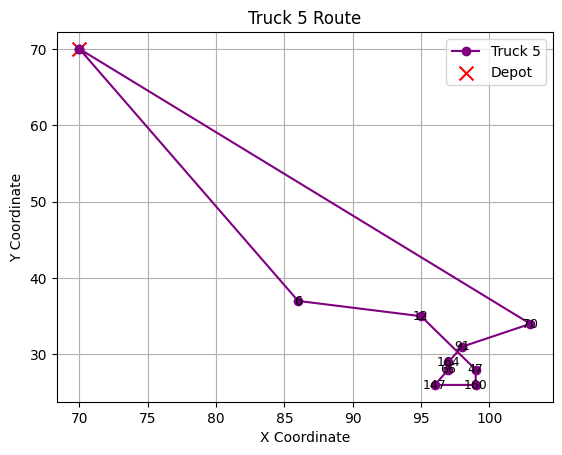

--------------------------------------------------
Truck #6
Path: depot -> 8 -> 88 -> 3 -> 98 -> 157 -> 18 -> 54 -> 185 -> 104 -> depot
Capacity used = 200
Total distance = 206.51
Total time = 1016.51


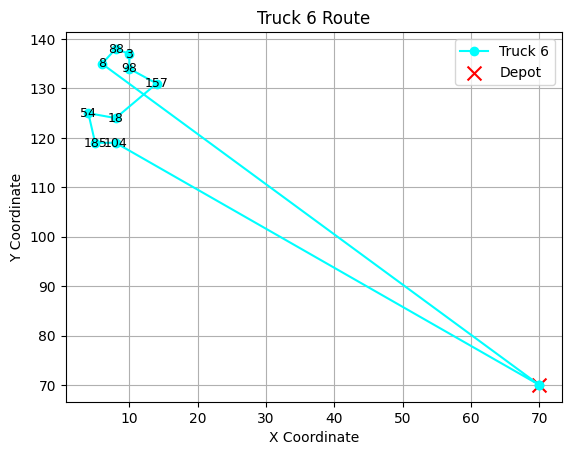

--------------------------------------------------
Truck #7
Path: depot -> 53 -> 99 -> 1 -> 9 -> 71 -> 126 -> 166 -> 119 -> 35 -> 101 -> 144 -> 183 -> 137 -> depot
Capacity used = 200
Total distance = 145.86
Total time = 1315.86


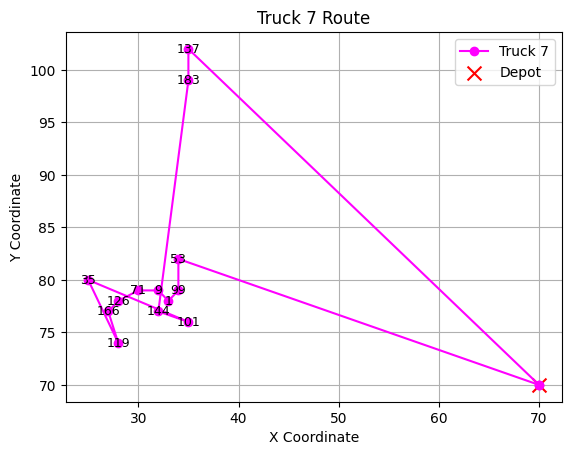

--------------------------------------------------
Truck #8
Path: depot -> 178 -> 27 -> 173 -> 80 -> 31 -> 25 -> 172 -> 77 -> 110 -> 162 -> 129 -> depot
Capacity used = 200
Total distance = 132.61
Total time = 1122.61


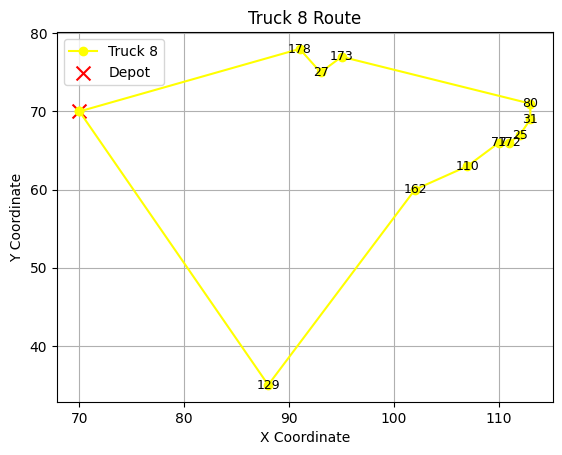

--------------------------------------------------
Truck #9
Path: depot -> 139 -> 11 -> 73 -> 116 -> 103 -> 148 -> 69 -> 141 -> 124 -> 197 -> depot
Capacity used = 200
Total distance = 177.35
Total time = 1077.35


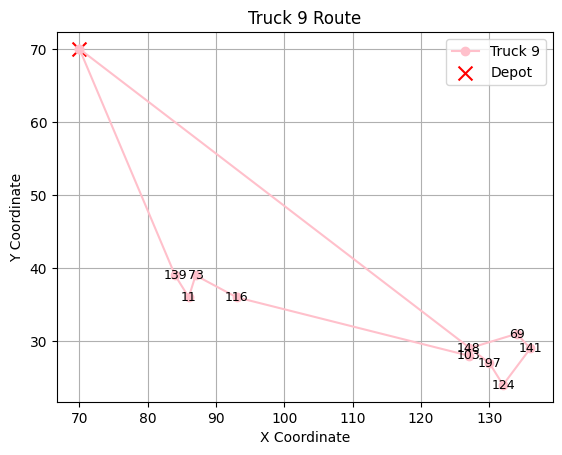

--------------------------------------------------
Truck #10
Path: depot -> 42 -> 50 -> 156 -> 112 -> 168 -> 79 -> 87 -> 29 -> 134 -> 170 -> 123 -> 153 -> depot
Capacity used = 200
Total distance = 159.45
Total time = 1239.45


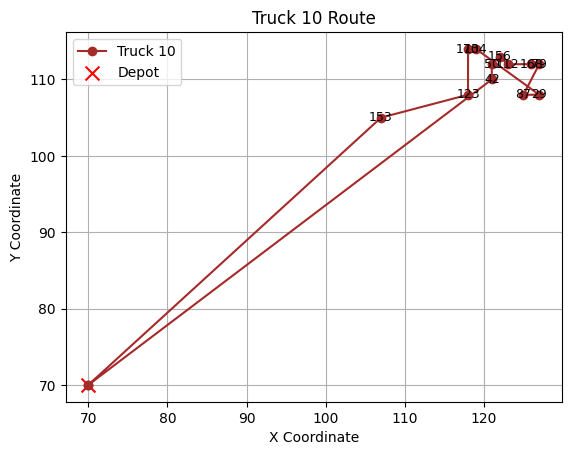

--------------------------------------------------
Truck #11
Path: depot -> 133 -> 48 -> 26 -> 152 -> 40 -> 198 -> 14 -> 59 -> 105 -> 89 -> 169 -> 15 -> depot
Capacity used = 200
Total distance = 123.68
Total time = 1203.68


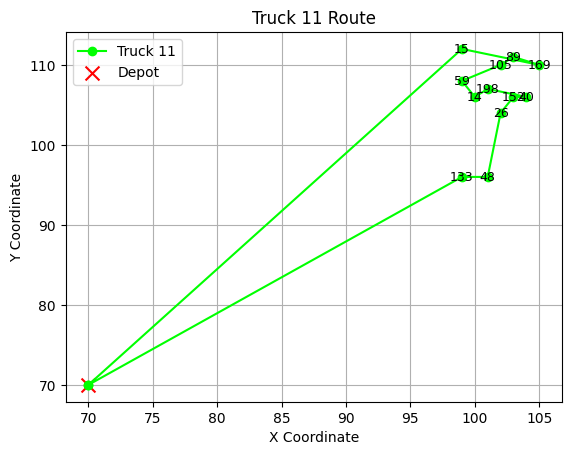

--------------------------------------------------
Truck #12
Path: depot -> 149 -> 28 -> 97 -> 196 -> 96 -> 130 -> 74 -> 192 -> 37 -> 199 -> 184 -> 135 -> depot
Capacity used = 190
Total distance = 189.25
Total time = 1269.25


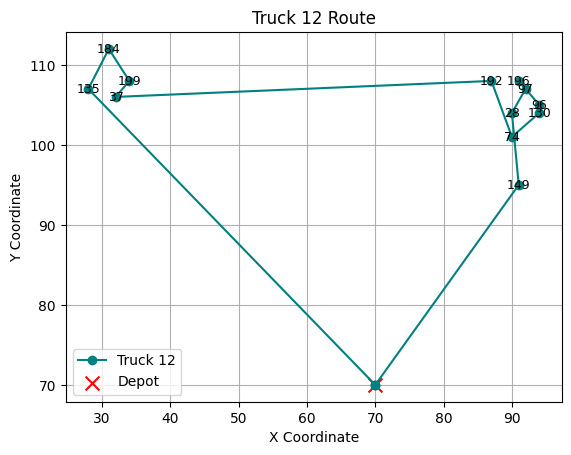

--------------------------------------------------
Truck #13
Path: depot -> 55 -> 93 -> 81 -> 138 -> 56 -> 114 -> 159 -> 38 -> 150 -> 22 -> 140 -> 187 -> depot
Capacity used = 190
Total distance = 201.79
Total time = 1281.79


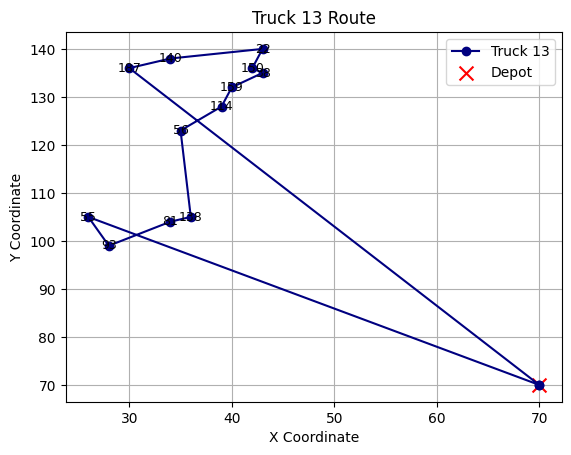

--------------------------------------------------
Truck #14
Path: depot -> 21 -> 23 -> 92 -> 52 -> 195 -> 145 -> 194 -> 163 -> 75 -> 182 -> depot
Capacity used = 200
Total distance = 182.19
Total time = 1082.19


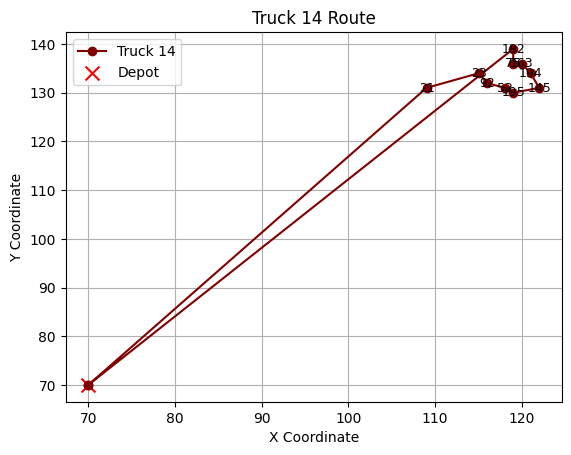

--------------------------------------------------
Truck #15
Path: depot -> 188 -> 165 -> 33 -> 121 -> 36 -> 108 -> 190 -> 158 -> 95 -> 34 -> 167 -> depot
Capacity used = 200
Total distance = 148.93
Total time = 1138.93


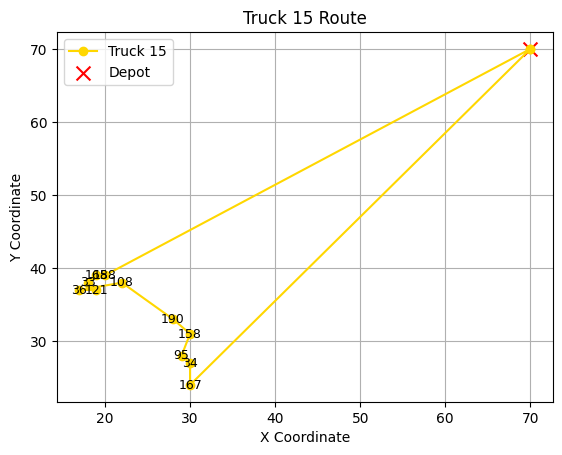

--------------------------------------------------
Truck #16
Path: depot -> 58 -> 161 -> 49 -> 117 -> 181 -> 7 -> 132 -> 127 -> 186 -> 177 -> 16 -> 142 -> depot
Capacity used = 180
Total distance = 229.52
Total time = 1309.52


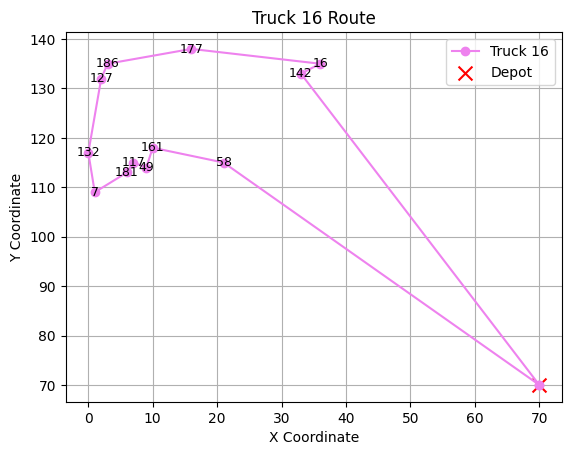

--------------------------------------------------
Truck #17
Path: depot -> 118 -> 5 -> 10 -> 106 -> 128 -> 46 -> 193 -> 63 -> 111 -> 151 -> depot
Capacity used = 180
Total distance = 263.53
Total time = 1163.53


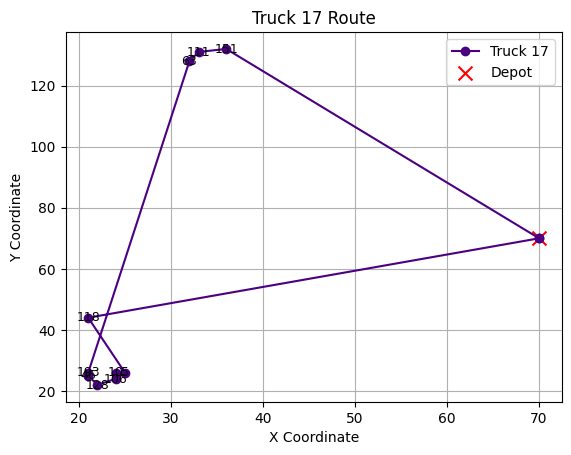

--------------------------------------------------
Truck #18
Path: depot -> 115 -> 86 -> 94 -> 51 -> 171 -> 65 -> 174 -> 136 -> 189 -> 32 -> 200 -> depot
Capacity used = 200
Total distance = 222.76
Total time = 1212.76


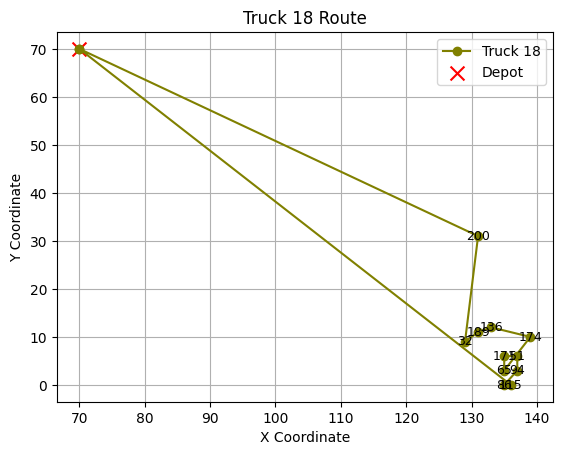

----------------------------------------------------------------------------------------------------
Total number of trucks used: 18
Max distance: 2987.31
Max global time: 1315.86
----------------------------------------------------------------------------------------------------


In [6]:
def read_dataset(file_path):
    print(f"Reading dataset -> {file_path}")
    # Reading the vehicle data (lines 3-4)
    vehicle_df = pd.read_csv(file_path, skiprows=4, nrows=1, sep='\\s+', names=['Number', 'Capacity'])
    
    # Reading the customer data (after line 9)
    customers_df = pd.read_csv(file_path, skiprows=9, sep='\\s+', names=['Cust No.', 'XCoord.', 'YCoord.', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

    truck_count = vehicle_df['Number'][0]  # Get the number of trucks
    capacity = vehicle_df['Capacity'][0]  # Get the capacity of each truck

    # Create a list of Customer objects from the customer data
    customers = [Customer(row['Cust No.'], row['XCoord.'], row['YCoord.'], row['Demand'], row['Ready Time'], row['Due Date'], row['Service Time']) for index, row in customers_df.iterrows()]
    
    return customers, truck_count, capacity

def do_excel():
    customers, truck_count, capacity = read_dataset(f'dataset/c101.txt') # Read the dataset from the input file
        
    # Print the vehicle data
    print(f"Number of trucks: {truck_count}")
    print(f"Capacity of each truck: {capacity}")
    print(f"Number of customers: {len(customers) - 1}")
    
    num_ants_list = [10, 15, 25]
    num_iterations_list = [20, 40]
    pheromon_importance_alpha_list = [0.5, 1.0, 1.5]
    heuristic_importance_beta_list = [1.0, 2.0, 3.0]
    evaporation_rho_list = [0.1, 0.2]
    pheromon_init_list = [0.1, 0.2, 0.5, 1.0]
    param_combinations = itertools.product(
        num_ants_list, num_iterations_list, pheromon_importance_alpha_list, heuristic_importance_beta_list, evaporation_rho_list, pheromon_init_list
    )
    
    index_column = []
    num_ants_column = []
    num_iterations_column = []
    pheromon_importance_alpha_column = []
    heuristic_importance_beta_column = []
    evaporation_rho_column = []
    pheromon_init_column = []
    truck_count_column = []
    lowest_distance_column = []
    average_distance_column = []
    best_distance_column = []
    
    i = 1
    product_len = len(num_ants_list) * len(num_iterations_list) * len(pheromon_importance_alpha_list) * len(heuristic_importance_beta_list) * len(evaporation_rho_list) * len(pheromon_init_list)
    
    for num_ants, num_iterations, pheromon_importance_alpha, heuristic_importance_beta, evaporation_rho, pheromon_init in param_combinations:
        print(f"Iteration N°{i}/{product_len}")
        print("-" * 100)
        print(f"Ant count: {num_ants}")
        print(f"Iteration count: {num_iterations}")
        print(f"Pheromon importance (alpha): {pheromon_importance_alpha}")
        print(f"Heuristic importance (beta): {heuristic_importance_beta}")
        print(f"Evaporation rate (rho): {evaporation_rho}")
        print(f"Initial pheromone level: {pheromon_init}")        
        print("-" * 100)

        # Initialize the Ant Colony Optimization (ACO) algorithm
        aco = ACO(
            customers.copy(),
            truck_count=truck_count,
            truck_capacity=capacity,
            iterations=num_iterations,
            ants_count=num_ants,
            pheromone_importance=pheromon_importance_alpha,
            heuristic_importance=heuristic_importance_beta,
            evaporation_rate=evaporation_rho,
            pheromone_init=pheromon_init,
            debug=False
        )

        # Run the ACO algorithm to find the best solution
        best_solution, best_cost = aco.run()
        best_solution = aco.remove_unused_trucks(best_solution)  # Remove unused trucks from the solution
        
        index_column.append(i)
        num_ants_column.append(num_ants)
        num_iterations_column.append(num_iterations)
        pheromon_importance_alpha_column.append(pheromon_importance_alpha)
        heuristic_importance_beta_column.append(heuristic_importance_beta)
        evaporation_rho_column.append(evaporation_rho)
        pheromon_init_column.append(pheromon_init)
        truck_count_column.append(len(best_solution))
        lowest_distance_column.append(min(aco.costs))
        average_distance_column.append(sum(aco.costs) / len(aco.costs))
        best_distance_column.append(max(aco.costs))

        # Plot the routes of the best solution
        # pr.plot_routes(best_solution, aco.depot)

        # Print the cost history
        # pr.print_costs_history(aco.costs)

        # Print the truck usage details
        pr.print_truck_usage(best_solution, aco.depot, show_graphics=False)
        
        i += 1
    
    excel_df = pd.DataFrame({"Ant count": num_ants_column, "Iteration count": num_iterations_column, "Pheromon importance (alpha)": pheromon_importance_alpha_column, "Heuristic importance (beta)": heuristic_importance_beta_column, "Evaporation rate (rho)": evaporation_rho_column, "Initial pheromone level": pheromon_init_column, "Lowest distance": lowest_distance_column, "Average distance": average_distance_column, "Best distance": best_distance_column})
    
    excel_df.to_excel('results.xlsx', index=True)  # Save the results to an Excel file
    

def main():
    customers, truck_count, capacity = read_dataset('dataset/c1_2_1.txt')  # Read the dataset from the input file
    # customers, truck_count, capacity = instance_generator(10)  # Generate a random instance of the vehicle routing problem
    
    nno = NNO(customers)
    distance = nno.run()

    # Print the vehicle data
    print(f"Number of trucks: {truck_count}")
    print(f"Capacity of each truck: {capacity}")
    print(f"Number of customers: {len(customers) - 1}")

    # Initialize the Ant Colony Optimization (ACO) algorithm
    aco = ACO(
        customers.copy(),
        truck_count=truck_count,
        truck_capacity=capacity,
        iterations=75,
        ants_count=50,
        pheromone_importance=1.0,
        heuristic_importance=2.0,
        evaporation_rate=0.1,
        pheromone_init=1/distance,
        debug=False
    )

    # Run the ACO algorithm to find the best solution
    best_solution, best_cost = aco.run()

    # Plot the routes of the best solution
    pr.plot_routes(best_solution, aco.depot)

    # Print the cost history
    pr.print_costs_history(aco.costs)

    # Print the truck usage details
    pr.print_truck_usage(best_solution, aco.depot)

if __name__ == '__main__':    
    # do_excel()
    main()